In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [391]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep="\s+", header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)

prcHist = pd.DataFrame(prcAll.T)

variance = prcHist.var()
stdev = np.sqrt(variance)

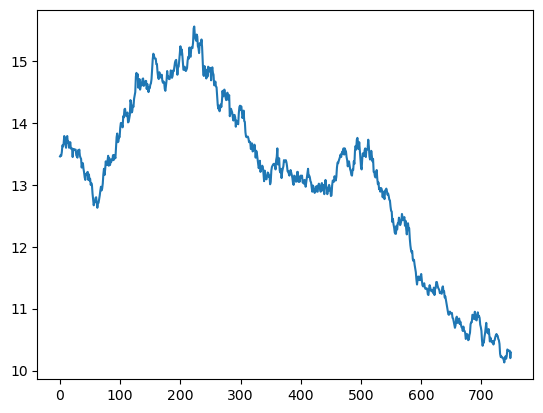

In [396]:
sample_stock = prcHist.iloc[:, 0]
plt.plot(sample_stock)
plt.vlines()

In [363]:
train_set = prcHist.iloc[:500, :]   # all columns from 1-50th
test_set = prcHist.iloc[500:750, :]


50

- Maybe try holt winter's multiplicative model &/or ridge regression later on. https://medium.com/@polanitzer/time-series-methodologies-part-8-holt-winters-multiplicative-seasonality-with-trend-8fda2feb53e5
https://medium.com/@polanitzer/time-series-analysis-in-python-predict-the-future-quarterly-sales-based-on-the-historical-sales-344946c1daf0



- LGBM addresses overfitting XGB adresses underfitting.

* ARIMA ? https://medium.com/@mvdg2001/stock-price-forecast-with-automatic-arima-order-selection-5593950a5393



Procedure:
1. Fit a MLS model to stock 1, see how it does and how it might be improved. done ish 
2. Using the MLS model predict t+1 price.
3. Generate features for the model.
4. Using the features and the prediction of the price, generate signals to trade.
5. Graphically determine flaws, for example, drawdowns or other potential pitfalls which hinder PnL
6. Apply this procedure once satisfied to the other 49 stocks.
7. Repeat 5 for general portfolio and look to address errors mentioned as addendums above.
8. HAVE FUN WITH THIS! AND LEARN AS MUCH AS YOU CAN.



Vector error correction model




Clearly Variance is high, however bias is low => overfit af.

Need corrolations => Choose between LASSO and Ridge to Regularize ? Maybe try both? => elastic net regression?

lets try some decomposition & signal processing first since ridge regression doesnt seem to help the future predictions much


^^ i didnt standardize so variance scaling mightve been messing up the model, lets try again.

In [302]:
scaler = StandardScaler()

In [306]:
scaled_train = pd.DataFrame(scaler.fit_transform(train_set))
scaled_test = pd.DataFrame(scaler.transform(test_set))

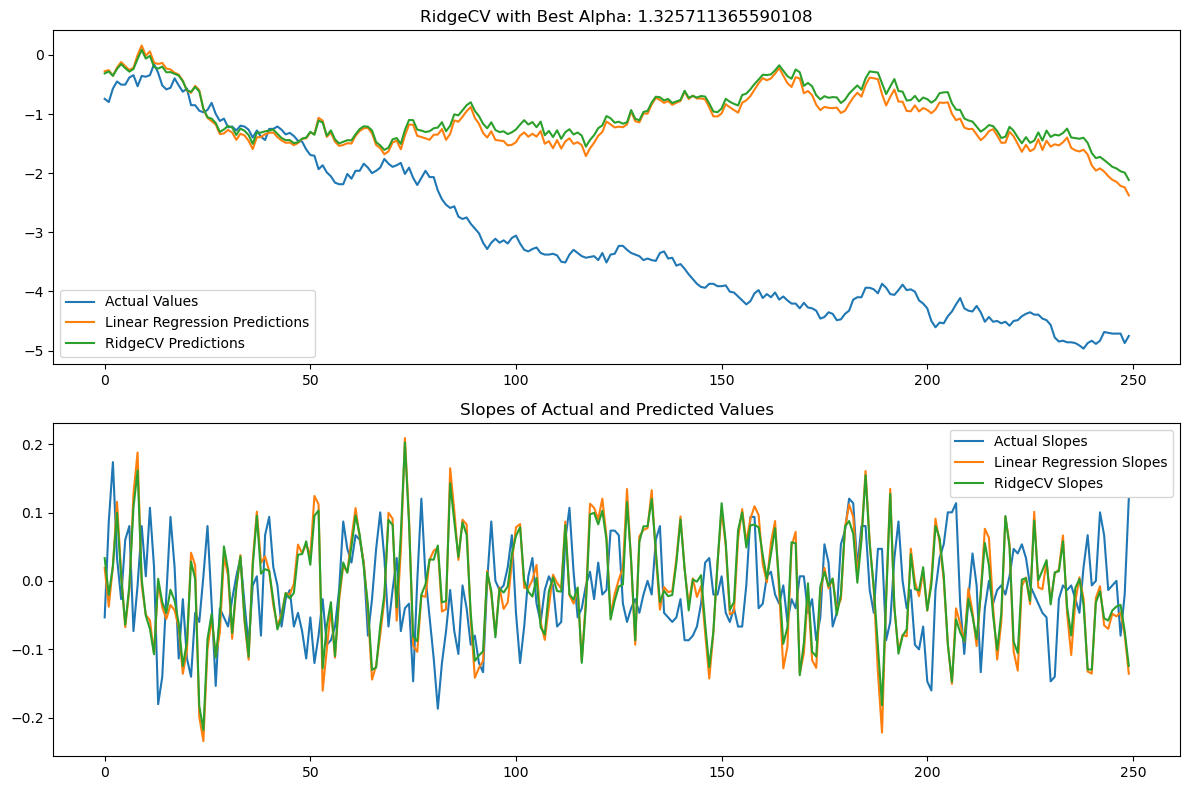

In [356]:
X_train_scaled = scaled_train.iloc[:, 1:50]
y_train_scaled = scaled_train.iloc[:, 0]
X_test_scaled = scaled_test.iloc[:, 1:50]
y_test_scaled = scaled_test.iloc[:, 0]


mlr_0 = LinearRegression().fit(X_train_scaled, y_train_scaled)
mlr_0_predict = mlr_0.predict(X_test_scaled)

alphas = np.logspace(-6, 6, 50)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train_scaled, y_train_scaled)
ridge_cv_predict = ridge_cv.predict(X_test_scaled)

mse_linear = mean_squared_error(y_test_scaled, mlr_0_predict)
mse_ridge = mean_squared_error(y_test_scaled, ridge_cv_predict)

slope_actual = np.gradient(y_test_scaled.values)
slope_mlr_0 = np.gradient(mlr_0_predict)
slope_ridge_cv = np.gradient(ridge_cv_predict)


# Plot the predictions and actual values
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(y_test_scaled.values, label="Actual Values")
plt.plot(mlr_0_predict, label="Linear Regression Predictions")
plt.plot(ridge_cv_predict, label="RidgeCV Predictions")
plt.legend()
plt.title(f"RidgeCV with Best Alpha: {ridge_cv.alpha_}")

# Plot the slopes (derivatives)
plt.subplot(2, 1, 2)
plt.plot(slope_actual, label="Actual Slopes")
plt.plot(slope_mlr_0, label="Linear Regression Slopes")
plt.plot(slope_ridge_cv, label="RidgeCV Slopes")
plt.legend()
plt.title("Slopes of Actual and Predicted Values")

plt.tight_layout()
plt.show()